In [1]:
#single image plot test
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.measure import regionprops
from cellpose import models, plot
import pandas as pd
import seaborn as sns
import os



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6 
platform:       	win32 
python version: 	3.12.10 
torch version:  	2.8.0+cu126! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




In [2]:

# INITIALIZATION (MUST BE RUN BEFORE THE FUNCTION IS CALLED)

# Load model (if not already)
model = models.CellposeModel(gpu=True)
rows = []
primary_id = 1
                    
def run_cell_analysis(ch2_path):
    """
    Performs Cellpose segmentation and feature extraction for a single image pair.
    The data is appended to the global 'rows' list.
    """
    print(f"/n--- Analyzing file: {os.path.basename(ch2_path)} ---")

    global rows
    rows = [] 
    global primary_id
    primary_id = 1

    # Assume ch2_path is the full path string (e.g., '.../HM_W001_P00001_CH2.tif')
    ch4_path = ch2_path.replace("_CH2.tif", "_CH4.tif")
    # 1. Load Images (as 2D grayscale)
    ch1_img = io.imread(ch2_path, as_gray=True)
    ch4_img = io.imread(ch4_path, as_gray=True)

    # 2. Run Cellpose (on the ch1/GFP channel)
    masks, flows, styles = model.eval([ch1_img],
                                      diameter=30,
                                      flow_threshold=0.4,
                                      cellprob_threshold=0.0)
    masks = masks[0]  # Unpack from list

    # 3. Measure Properties for BOTH channels using the SAME masks
    # The redundant [:, :] slicing is removed for cleaner code.
    props = regionprops(masks, intensity_image=ch1_img)
    ch4_props = regionprops(masks, intensity_image=ch4_img)
    
    # Get File Name (for tracking)
    file_name = os.path.splitext(os.path.basename(ch2_path))[0]

    # 4. COMBINE DATA INTO ONE ROW PER CELL (The main fix)
    # The 'props' and 'ch4_props' lists are guaranteed to be in the same order 
    # and correspond to the same labels, so we use zip().
    for p_gfp, p_s647 in zip(props, ch4_props):
        rows.append({
            "file": file_name,
            "primary_id": primary_id,
            "cell_id": p_gfp.label,
            "area_px": p_gfp.area,
            "mean_gfp": p_gfp.mean_intensity,
            "mean_s647": p_s647.mean_intensity # Both intensities are now in one row
        })
    
    primary_id += 1
    

In [8]:
# --- Execute the function for both channels ---
# 1. Run analysis for CH2
# CH_basepath = "C:/Users/labadmin/Documents/BZ-X800/Chris/Psychatg02_07112025/"
# ch2_path = os.path.join(CH_basepath, filename + "_CH2.tif")
CH2 = "C:/Users/labadmin/Documents/BZ-X800/Chris/ChrisCodeTest/Converted_2025-11-13_Cast_wholeBrain_confocal_/DMT_female_4 CaST_1.ome.tiff"
# CH4 = "C:/Users/labadmin/Documents/BZ-X800/Chris/Psychatg02_07112025/S+B+_w1/W001/P00001/HM_W001_P00001_CH4.tif"

run_cell_analysis(CH2)
df_Splus = pd.DataFrame(rows)

CH2 = "C:/Users/labadmin/Documents/BZ-X800/Chris/ChrisCodeTest/Converted_2025-11-13_Cast_wholeBrain_confocal_/Saline_female_1 CaST_1.ome.tiff"
# CH4 = "C:/Users/labadmin/Documents/BZ-X800/Chris/Psychatg02_07112025/B+_w1/W001/P00001/HM_W001_P00001_CH4.tif"
run_cell_analysis(CH2)
df_Sminus = pd.DataFrame(rows)
# df_all = pd.DataFrame(rows)

print(f"df_Splus now has {len(df_Splus)} rows.")
print(f"df_Sminus now has {len(df_Sminus)} rows.")

/n--- Analyzing file: DMT_female_4 CaST_1.ome.tiff ---
/n--- Analyzing file: Saline_female_1 CaST_1.ome.tiff ---
df_Splus now has 10 rows.
df_Sminus now has 5 rows.


In [9]:
# Tina delete later#
# --- Execute the function for both channels ---
# 1. Run analysis for CH2
# CH_basepath = "C:/Users/labadmin/Documents/BZ-X800/Chris/Psychatg02_07112025/S+B+_w1/"

# all_filenames = ["FOV1","FOV2","FOV3"];
# df=[];
# for z=1:len(all_filenames)
#     rows = []
#     primary_id = 1
#     run_cell_analysis(strcat(CH_basepath+all_filenames(z)+"_CH2.tif"), strcat(CH_basepath+all_filenames(z)+"_CH4.tif");
#     df = [df; pd.DataFrame(rows)]
# end



In [10]:
df = pd.DataFrame(rows)
df

,file,primary_id,cell_id,area_px,mean_gfp,mean_s647
0,Saline_female_1 CaST_1.ome,1,1,3621.0,0.016491,0.016491
1,Saline_female_1 CaST_1.ome,1,2,2586.0,0.016648,0.016648
2,Saline_female_1 CaST_1.ome,1,3,5303.0,0.021424,0.021424
3,Saline_female_1 CaST_1.ome,1,4,5143.0,0.023409,0.023409
4,Saline_female_1 CaST_1.ome,1,5,2197.0,0.013973,0.013973


In [11]:
df_Splus

,file,primary_id,cell_id,area_px,mean_gfp,mean_s647
0,DMT_female_4 CaST_1.ome,1,1,5255.0,0.034004,0.034004
1,DMT_female_4 CaST_1.ome,1,2,5369.0,0.026560,0.026560
2,DMT_female_4 CaST_1.ome,1,3,4376.0,0.022531,0.022531
3,DMT_female_4 CaST_1.ome,1,4,8090.0,0.027673,0.027673
4,DMT_female_4 CaST_1.ome,1,5,4724.0,0.025160,0.025160
5,DMT_female_4 CaST_1.ome,1,6,4396.0,0.022135,0.022135
6,DMT_female_4 CaST_1.ome,1,7,5651.0,0.022270,0.022270
7,DMT_female_4 CaST_1.ome,1,8,2413.0,0.022230,0.022230
8,DMT_female_4 CaST_1.ome,1,9,3915.0,0.022025,0.022025
9,DMT_female_4 CaST_1.ome,1,10,4845.0,0.035371,0.035371


In [12]:
df_Sminus

,file,primary_id,cell_id,area_px,mean_gfp,mean_s647
0,Saline_female_1 CaST_1.ome,1,1,3621.0,0.016491,0.016491
1,Saline_female_1 CaST_1.ome,1,2,2586.0,0.016648,0.016648
2,Saline_female_1 CaST_1.ome,1,3,5303.0,0.021424,0.021424
3,Saline_female_1 CaST_1.ome,1,4,5143.0,0.023409,0.023409
4,Saline_female_1 CaST_1.ome,1,5,2197.0,0.013973,0.013973


In [13]:
#concat the S+ and S-
df_Splus['Condition'] = 'S+B+'
df_Sminus['Condition'] = 'S-B+'

# Combine the two DataFrames
df_combined = pd.concat([df_Splus, df_Sminus], ignore_index=True)
df_combined['ratio_s647_gfp'] = df_combined['mean_s647'] / (df_combined['mean_gfp'] + 1e-9)

<Axes: xlabel='Condition', ylabel='ratio_s647_gfp'>

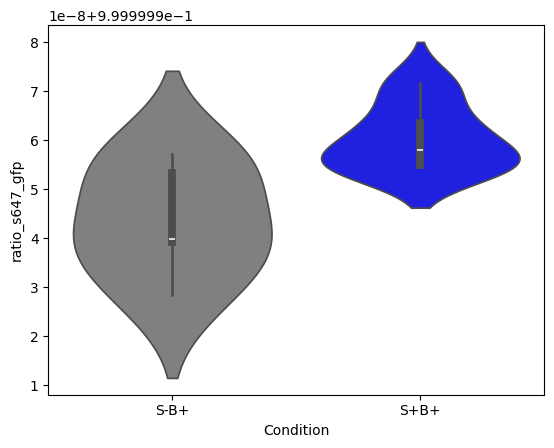

In [14]:
#violin plot 
sns.violinplot(
    data=df_combined,
    x='Condition',
    y='ratio_s647_gfp',
    hue='Condition',  # ADDED: Assign x to hue as recommended
    legend=False,     # ADDED: Hide the redundant legend
    palette=['blue', 'gray'],
    order=['S-B+', 'S+B+']
)

In [15]:
df_combined

,file,primary_id,cell_id,area_px,mean_gfp,mean_s647,Condition,ratio_s647_gfp
0,DMT_female_4 CaST_1.ome,1,1,5255.0,0.034004,0.034004,S+B+,1.0
1,DMT_female_4 CaST_1.ome,1,2,5369.0,0.026560,0.026560,S+B+,1.0
2,DMT_female_4 CaST_1.ome,1,3,4376.0,0.022531,0.022531,S+B+,1.0
3,DMT_female_4 CaST_1.ome,1,4,8090.0,0.027673,0.027673,S+B+,1.0
4,DMT_female_4 CaST_1.ome,1,5,4724.0,0.025160,0.025160,S+B+,1.0
5,DMT_female_4 CaST_1.ome,1,6,4396.0,0.022135,0.022135,S+B+,1.0
6,DMT_female_4 CaST_1.ome,1,7,5651.0,0.022270,0.022270,S+B+,1.0
7,DMT_female_4 CaST_1.ome,1,8,2413.0,0.022230,0.022230,S+B+,1.0
8,DMT_female_4 CaST_1.ome,1,9,3915.0,0.022025,0.022025,S+B+,1.0
9,DMT_female_4 CaST_1.ome,1,10,4845.0,0.035371,0.035371,S+B+,1.0


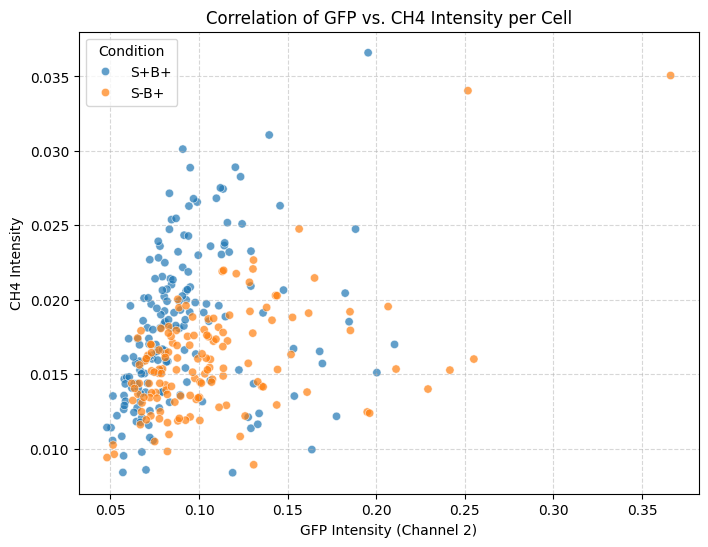

In [11]:
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=df_combined,
    x='mean_gfp',
    y='mean_s647',
    hue='Condition',  # Use the new column to distinguish colors
    alpha=0.7         # Set transparency for better visibility of overlapping points
)

plt.xlabel("GFP Intensity (Channel 2)")
plt.ylabel("CH4 Intensity")
plt.title("Correlation of GFP vs. CH4 Intensity per Cell")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [12]:
# Save mask
#mask_path = save_folder / f"{all_files[i].stem}_mask.tif"
mask_path = "C:/Users/labadmin/Documents/BZ-X800/Chris/Psychatg02_07112025/cellpose" / f"mask.tif"
io.imsave(mask_path, masks[0])

TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [ ]:
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, ch1_img, masks, flows[0])
plt.tight_layout()
plt.show()